In [1]:
import numpy as np
import math
from scipy.spatial import distance
from warnings import warn
import time
from pathlib import Path

In [2]:
from cpp_algorithms.testers import imshow, imshow_scatter
from cpp_algorithms.testers import get_all_area_maps, get_random_coords, get_area_map
from cpp_algorithms.testers.metrics import coverage_metrics
from cpp_algorithms.testers.display_funcs import printer
from cpp_algorithms.testers import is_valid

# A - Star
(untouched)

In [3]:
def backTrackingList(Memory, diameter, M, Critical_x, Critical_y):
    resultList=[]
    backup=[]
    flag=0
    
    for a in Memory:
        x=a[0]
        y=a[1]
        sum1=0
        
        if(sum(map(sum, M[x:x-diameter:-1, y+diameter:y+2*diameter])) == 255*diameter*diameter and (sum(map(sum, M[x:x+diameter, y+diameter:y+2*diameter]))<255*diameter*diameter   or sum(map(sum, M[x:x+diameter, y+diameter:y+2*diameter])) == 150*diameter*diameter)):
            sum1=sum1+1
        
        if(sum(map(sum, M[x:x-diameter:-1, y+diameter:y+2*diameter])) == 255*diameter*diameter and (sum(map(sum, M[x-diameter:x-2*diameter:-1, y+diameter:y+2*diameter])) <255*diameter*diameter or sum(map(sum, M[x-diameter:x-2*diameter:-1, y+diameter:y+2*diameter])) == 150*diameter*diameter)):
            sum1=sum1+1
            
        if(sum(map(sum, M[x:x-diameter:-1, y-diameter:y])) == 255*diameter*diameter and (sum(map(sum, M[x:x+diameter, y:y-diameter:-1])) <255*diameter*diameter  or sum(map(sum, M[x:x+diameter, y:y-diameter:-1])) == 150*diameter*diameter)):
            sum1=sum1+1
            
            
        if(sum(map(sum, M[x:x-diameter:-1, y-diameter:y])) == 255*diameter*diameter and (sum(map(sum, M[x-diameter:x-2*diameter:-1, y:y-diameter:-1]))<255*diameter*diameter or sum(map(sum, M[x-diameter:x-2*diameter:-1, y:y-diameter:-1])) == 150*diameter*diameter)):
            sum1=sum1+1
            
        if(sum(map(sum, M[x+diameter:x:-1, y:y+diameter])) == 255*diameter*diameter and (sum(map(sum, M[x:x+diameter, y:y-diameter:-1])) <255*diameter*diameter or sum(map(sum, M[x:x+diameter, y:y-diameter:-1])) == 150*diameter*diameter)):
            sum1=sum1+1
            
        if(sum(map(sum, M[x+diameter:x:-1, y:y+diameter])) == 255*diameter*diameter and (sum(map(sum, M[x:x+diameter, y+diameter:y+2*diameter])) <255*diameter*diameter or sum(map(sum, M[x:x+diameter, y+diameter:y+2*diameter])) == 150*diameter*diameter)):
            sum1=sum1+1
        
        if(sum1==0 and (sum(map(sum, M[x-diameter: x-2*diameter:-1, y:y+diameter])) ==255*diameter*diameter or sum(map(sum, M[x+diameter: x:-1, y:y+diameter])) == 255*diameter*diameter or sum(map(sum, M[x: x-diameter:-1, y+diameter: y+2*diameter]))==255*diameter*diameter or sum(map(sum, M[x: x-diameter:-1, y-diameter: y])) ==255*diameter*diameter)):
            backup.append(a)
            
        if sum1 >= 1:
            resultList.append(a)
            
            
    if (len(resultList) ==0 and len(backup)==0):
        return 0, 0
    
    if(len(resultList)!=0):
        if(len(resultList)==1):
            for i in resultList:
                x=i[0]
                y=i[1]
                #print(x, y)
                return x, y
             
        else:
            minimum=[]
            for z in resultList:
                p1=(Critical_x, Critical_y)
                p2=(z[0], z[1])
                d=distance.euclidean(p1, p2)
                minimum.append(d)
                #print(minimum)
                
    else:
        flag=1
        if(len(backup)==1):
            for i in backup:
                x=i[0]
                y=i[1]
                return x,y
        else:
            minimum=[]
            for z in backup:
                p1=(Critical_x, Critical_y)
                p2=(z[0], z[1])
                d=distance.euclidean(p1, p2)
                minimum.append(d)
            
        
            
    min1=minimum[0]
    index=0
        
    for p in range(len(minimum)):
        if minimum[p] < min1:
            index=p
    
    list_of_coord=[] 
    if(flag==1):
        list_of_coord=backup[index]
    else:
        list_of_coord=resultList[index]
    
    return list_of_coord[0], list_of_coord[1]

In [4]:
def heuristic(start, goal):
    #Use Chebyshev distance heuristic if we can move one square either
    #adjacent or diagonal
    D = 1
    D2 = 1
    dx = abs(start[0] - goal[0])
    dy = abs(start[1] - goal[1])
    return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy)
    
def get_vertex_neighbours(pos, diameter, width, height):
    n = []
    #Moves allow link a chess king
    for dx, dy in [(diameter,0),(-diameter,0),(0,diameter),(0,-diameter)]:
        x2 = pos[0] + dx
        y2 = pos[1] + dy
        if x2 < 0 or x2 > width-1  or y2 < 0 or y2 > height-1:
            continue
        n.append((x2, y2))
    return n
    

In [5]:
def AStarSearch(start, end, graph, diameter, width, height):
 
    G = {} #Actual movement cost to each position from the start position
    F = {} #Estimated movement cost of start to end going via this position
 
    #Initialize starting values
    G[start] = 0 
    F[start] = heuristic(start, end)
 
    closedVertices = set()
    openVertices = set([start])
    cameFrom = {}
    
    # Adding a stop condition
    outer_iterations = 0
    max_iterations = (len(graph[0]) * len(graph) // 2)
 
    while len(openVertices) > 0:
        outer_iterations += 1

        if outer_iterations > max_iterations:
            warn("giving up on pathfinding too many iterations")
            
        #Get the vertex in the open list with the lowest F score
        current = None
        currentFscore = None
        for pos in openVertices:
            if current is None or F[pos] < currentFscore:
                currentFscore = F[pos]
                current = pos
 
        #Check if we have reached the goal
        if current == end:
            #Retrace our route backward
            path = [current]
            while current in cameFrom:
                current = cameFrom[current]
                path.append(current)
            path.reverse()
            return path  #Done!
 
        #Mark the current vertex as closed
        openVertices.remove(current)
        closedVertices.add(current)
 
        #Update scores for vertices near the current position
        for neighbour in get_vertex_neighbours(current, diameter, width, height):
            if neighbour in closedVertices: 
                continue #We have already processed this node exhaustively
            x=neighbour[0]
            y=neighbour[1]
            if graph[x][y]!=150:
                continue
            else:
                candidateG = G[current] + 1
 
            if neighbour not in openVertices:
                openVertices.add(neighbour) #Discovered a new vertex
            
            elif candidateG >= G[neighbour]:
                continue #This G score is worse than previously found
 
            #Adopt this G score
            cameFrom[neighbour] = current
            G[neighbour] = candidateG
            H = heuristic(neighbour, end)
            F[neighbour] = G[neighbour] + H
 
    raise RuntimeError("A* failed to find a solution")

In [6]:
def AstarPath(M, Memory, path):
    for q in path:
        x=q[0]
        y=q[1]
        Memory.append((x, y))

# Boustrophedon and caller

In [7]:
def bous_preprocess(area_map):
    """
    Returns matrix that in the form
    that is read by the main algorithm.
    """
    matrix = np.full(area_map.shape, 0, dtype=np.uint8)
    matrix[area_map == 0] = 255
    return matrix

def do_everything(matrix, start_point, break_after_bous=False):
    start_time = time.time()
    
    width, height = matrix.shape
    radius=0.5
    diameter=int(2*radius)

    x, y = start_point
    memory=[]

    Flag=True
    while True:
        critical_x, critical_y = boustrophedon(matrix, diameter, x, y, memory)
        
        if break_after_bous:
            print("break point",critical_x,critical_y)
            break
            
        x, y = backTrackingList(memory, diameter, matrix, critical_x, critical_y)
        if(x == 0 and y == 0):
            Flag=False
            break
        else:
            start = (critical_x,critical_y )
            end = (x, y)
            path = AStarSearch(start, end, matrix, diameter, width, height)
            AstarPath(matrix, memory, path)
            
    return memory 

In [8]:
def visit(matrix, x, y, memory):
    matrix[(x,y)] = 150 # 150 == visited
    memory.append((x, y))
    return x,y

def boustrophedon(matrix, diameter, x, y, memory):
    # TODO :: Variable diameter support
    udlr = {
        "u": lambda x,y : (x-diameter,y),
        "d": lambda x,y : (x+diameter,y),
        "l": lambda x,y : (x,y-diameter),
        "r": lambda x,y : (x,y+diameter)
    }
    u = "u";d = "d";r = "r";l = "l"
    visit(matrix, x, y, memory)
    
    while True:
        dir_ = [u,d,r,l]
        while len(dir_) > 0:
            d_ = dir_.pop(0)
            x_, y_ = udlr[d_](x,y)
            if is_valid((x_,y_), matrix, [0, 150]):
                x, y = visit(matrix, x_, y_, memory)
                break
            elif d_ == l:
                return x, y

In [9]:
area_maps = get_all_area_maps("./test_maps/")

Wall time: 4.91 s
     points_to_visit : 772
     obstacle_points : 252
      points_visited : 772
   coverage_path_len : 1188
            coverage : 1.0
          redundancy : 0.5388601036269429
          area_shape : (32, 32)



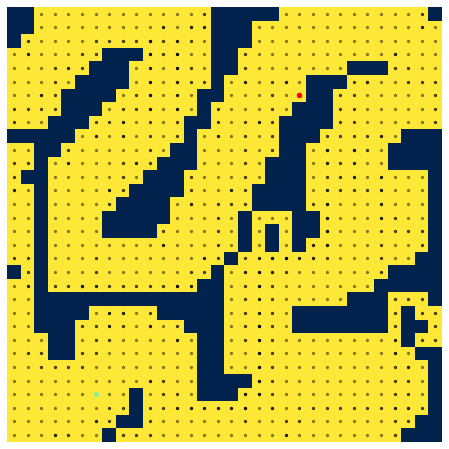

In [10]:
area_map = area_maps[5]
#area_map = np.full((100,100), 0)
start_point = (28,6)
#start_point = get_random_coords(area_map, 1)[0]
matrix = bous_preprocess(area_map)
%time coverage_path = do_everything(matrix, start_point, break_after_bous=False)
end_point = coverage_path[-1]

printer(coverage_metrics(area_map, coverage_path))
print()

imshow(matrix, figsize=(8, 8), cmap="cividis")                       #Shift + Tab
imshow_scatter(coverage_path, alpha=0.4, color="black",s=5)
imshow_scatter([start_point],color="lightgreen")
imshow_scatter([end_point],color="red")

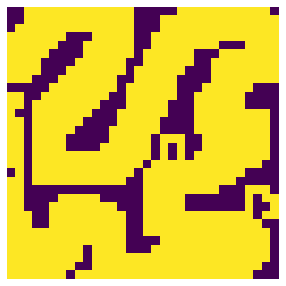

In [12]:
imshow(area_maps[5])

Wall time: 4.33 s
start: (0, 24), end: (8, 29)
     points_to_visit : 772
     obstacle_points : 252
      points_visited : 772
   coverage_path_len : 1152
            coverage : 1.0
          redundancy : 0.49222797927461137
          area_shape : (32, 32)

Wall time: 5.08 s
start: (28, 3), end: (6, 21)
     points_to_visit : 772
     obstacle_points : 252
      points_visited : 772
   coverage_path_len : 1199
            coverage : 1.0
          redundancy : 0.5531088082901554
          area_shape : (32, 32)

Wall time: 4.74 s
start: (12, 26), end: (6, 21)
     points_to_visit : 772
     obstacle_points : 252
      points_visited : 772
   coverage_path_len : 1116
            coverage : 1.0
          redundancy : 0.4455958549222798
          area_shape : (32, 32)

Wall time: 4.88 s
start: (12, 8), end: (4, 5)
     points_to_visit : 772
     obstacle_points : 252
      points_visited : 772
   coverage_path_len : 1164
            coverage : 1.0
          redundancy : 0.5077720207253886


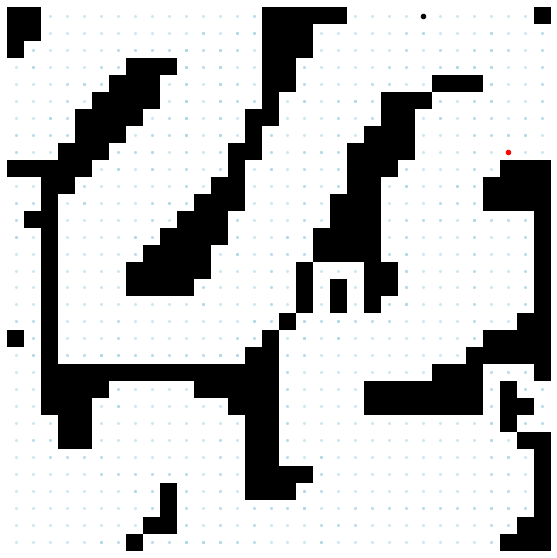

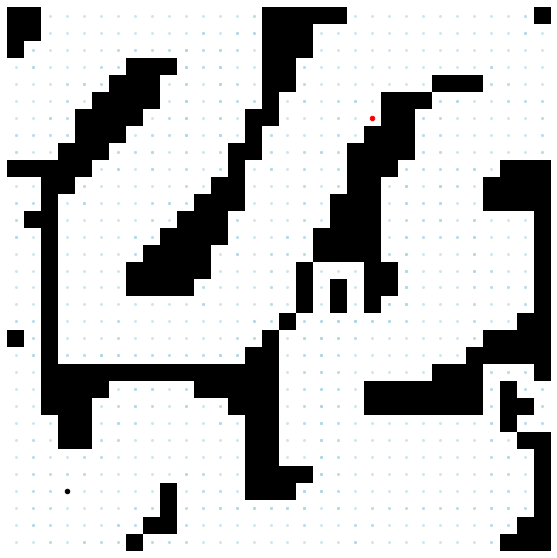

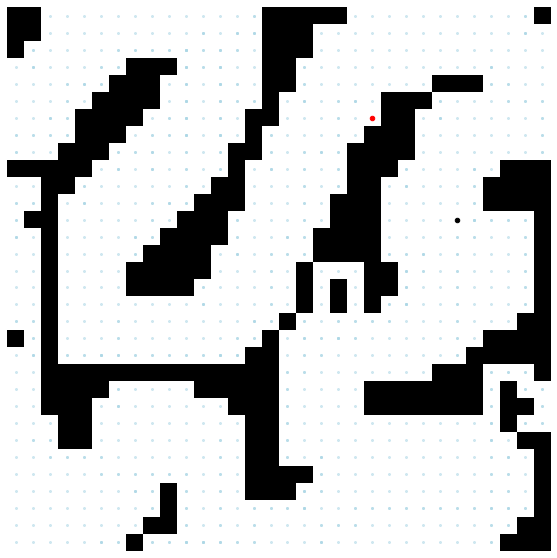

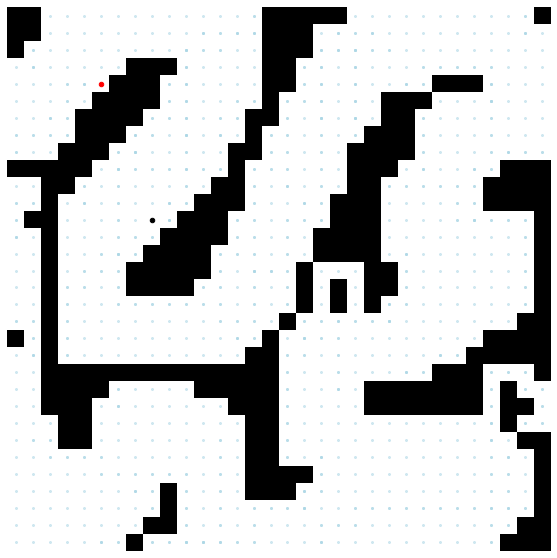

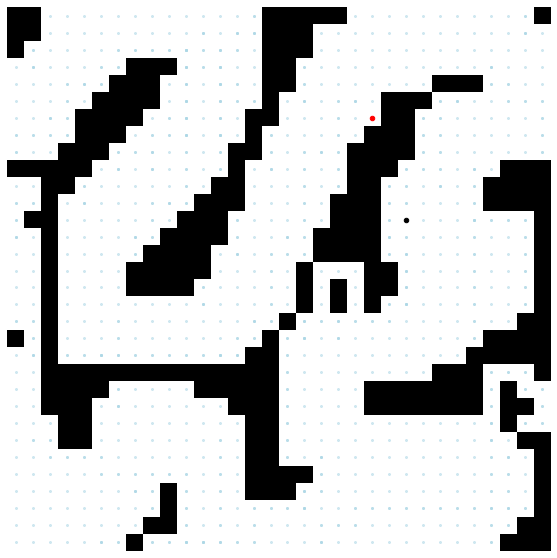

In [14]:
area_map = area_maps[5]
for i in range(5):
    start_point = get_random_coords(area_map, 1)[0]
    matrix = bous_preprocess(area_map)
    %time coverage_path = do_everything(matrix, start_point)
    end_point = coverage_path[-1]
    print(f"start: {start_point}, end: {end_point}")
    printer(coverage_metrics(area_map, coverage_path))
    print()

    imshow(matrix, cmap="Greys_r",figsize=(10,10))
    imshow_scatter(coverage_path, alpha=0.5, color="lightblue",s=4)
    imshow_scatter([start_point], color="black")
    imshow_scatter([end_point],color="red")
    

# 0 ::  (32, 32) caves_0.png
Wall time: 974 ms
     points_to_visit : 725
     obstacle_points : 299
      points_visited : 725
   coverage_path_len : 876
            coverage : 1.0
          redundancy : 0.20827586206896553
          area_shape : (32, 32)

# 1 ::  (32, 32) caves_1.png


<ipython-input-5-2298b70604af>:22: UserWarning: giving up on pathfinding too many iterations
  warn("giving up on pathfinding too many iterations")


Wall time: 1.16 s
     points_to_visit : 794
     obstacle_points : 230
      points_visited : 794
   coverage_path_len : 919
            coverage : 1.0
          redundancy : 0.15743073047858935
          area_shape : (32, 32)

# 2 ::  (32, 32) center_0.png
Wall time: 2.23 s
     points_to_visit : 723
     obstacle_points : 301
      points_visited : 723
   coverage_path_len : 941
            coverage : 1.0
          redundancy : 0.30152143845089907
          area_shape : (32, 32)

# 3 ::  (144, 256) center_1.png
Wall time: 1min 43s
     points_to_visit : 36713
     obstacle_points : 151
      points_visited : 36713
   coverage_path_len : 37452
            coverage : 1.0
          redundancy : 0.020129109579712923
          area_shape : (144, 256)

# 4 ::  (50, 50) comb_0.png
Wall time: 6.65 s
     points_to_visit : 1529
     obstacle_points : 971
      points_visited : 1529
   coverage_path_len : 1906
            coverage : 1.0
          redundancy : 0.24656638325703084
          are

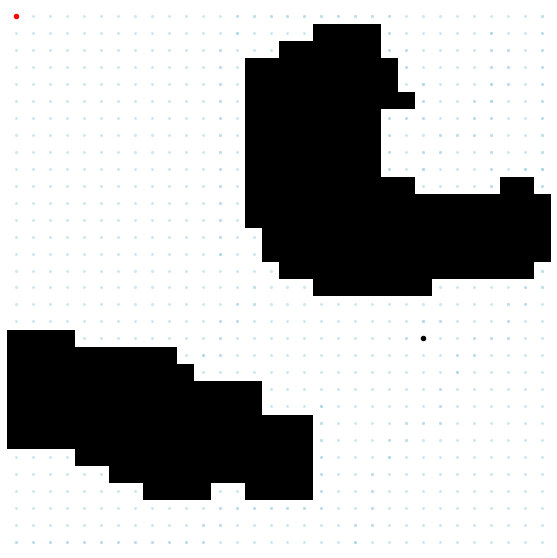

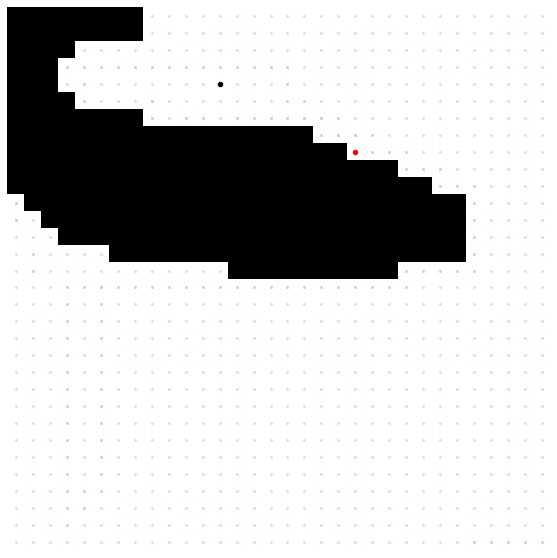

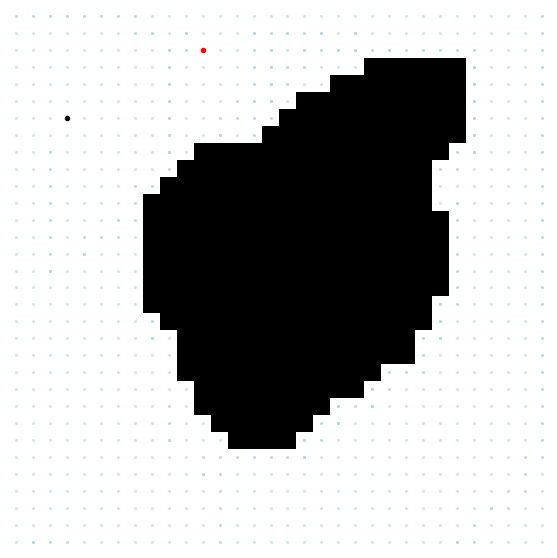

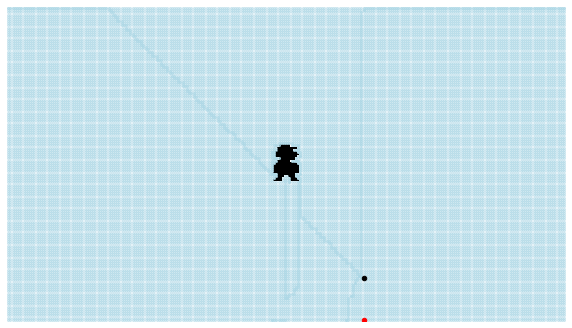

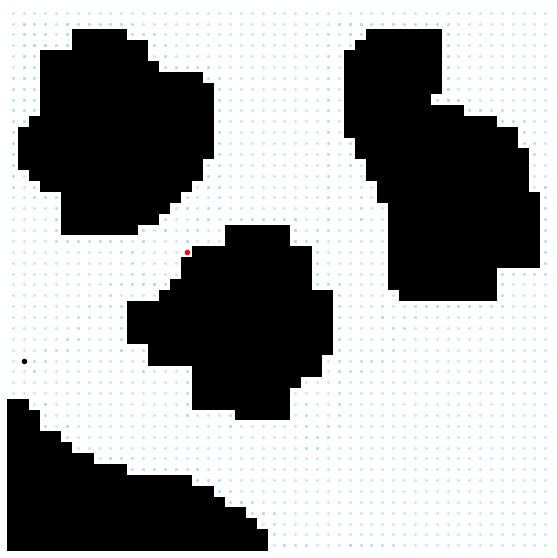

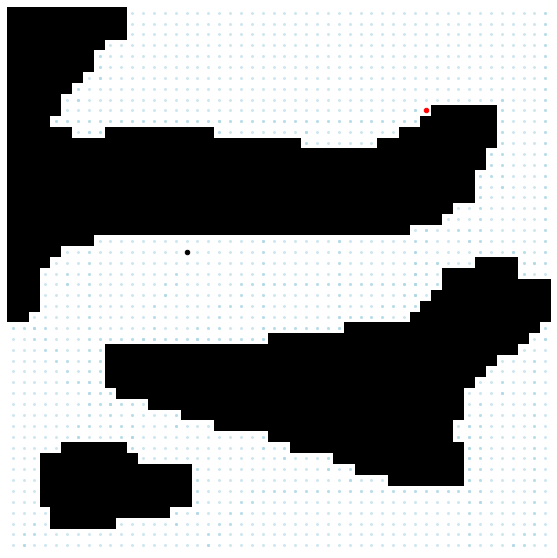

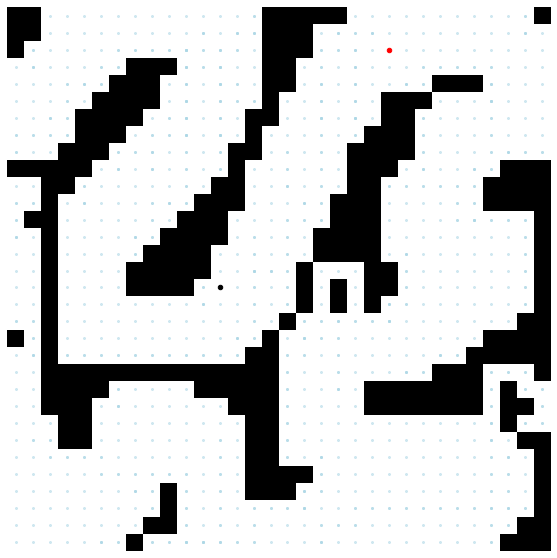

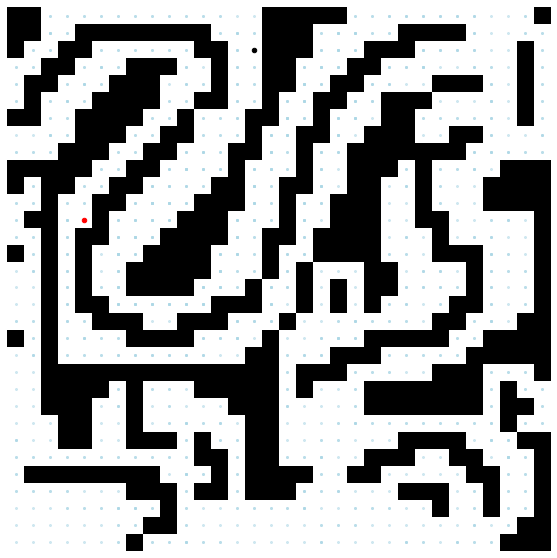

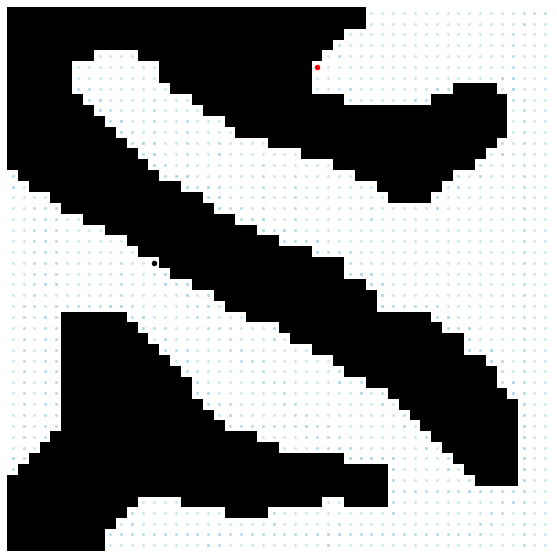

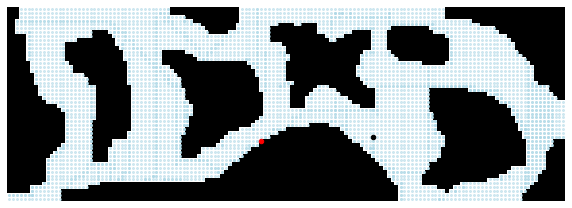

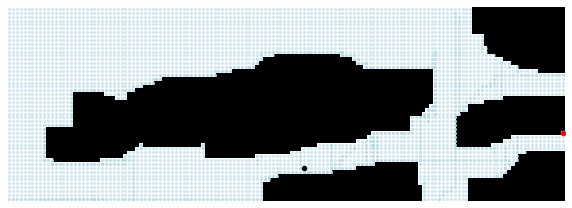

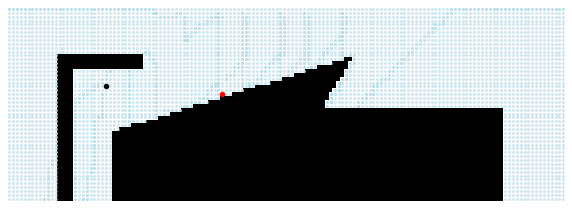

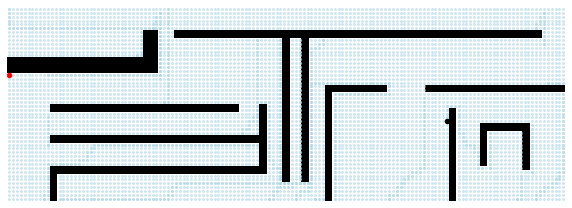

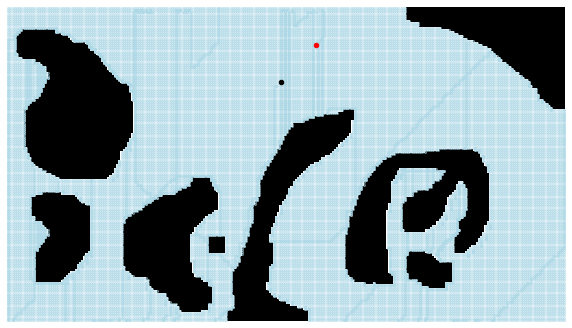

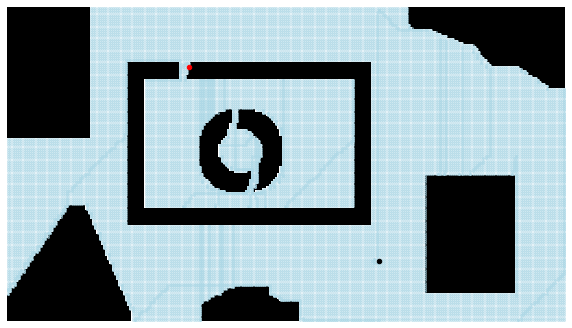

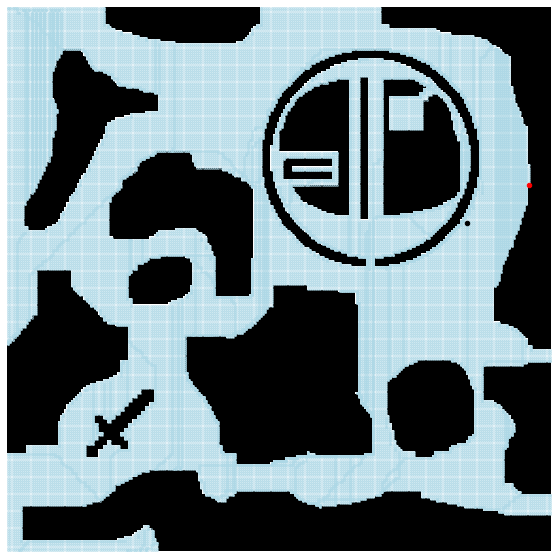

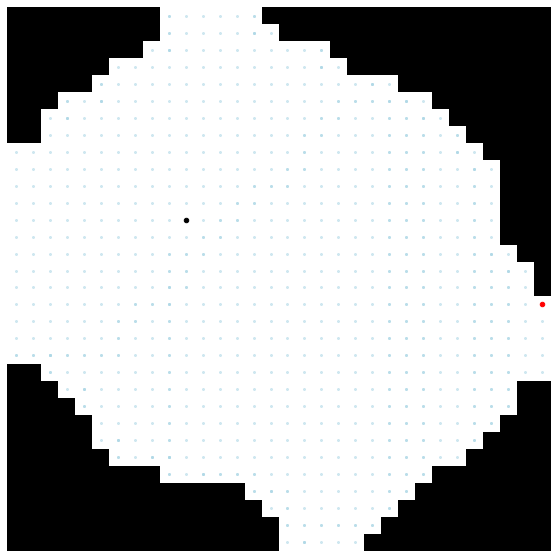

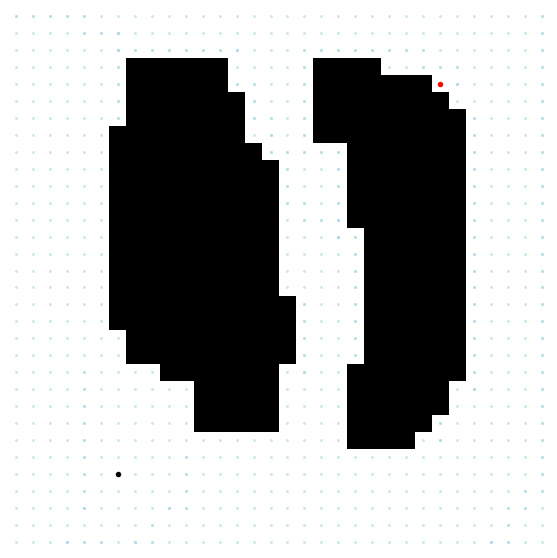

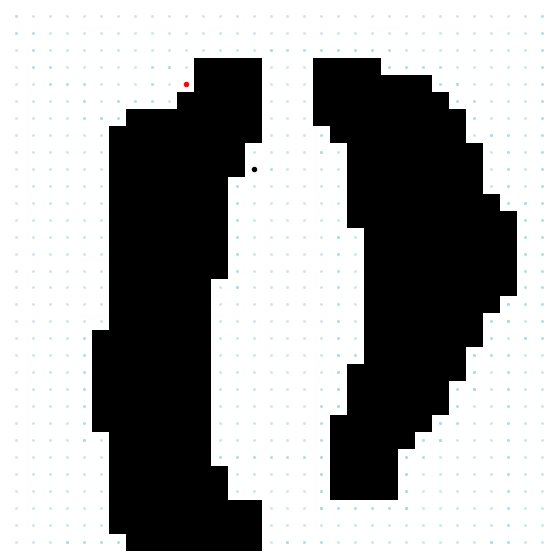

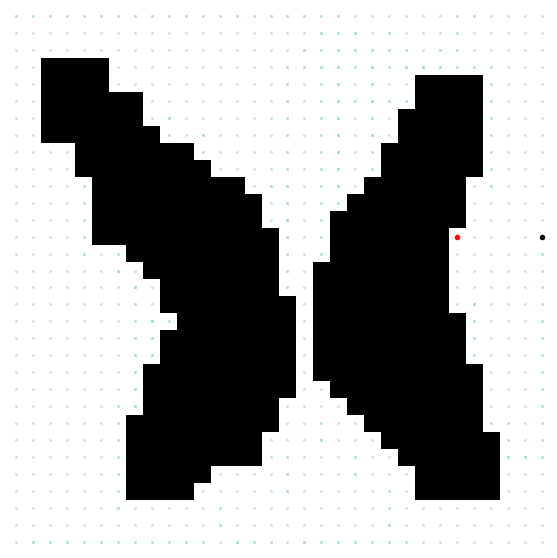

In [15]:
for i,path in enumerate(Path("./test_maps/").iterdir()):
    if path.suffix != ".png":
        continue
    area_map = get_area_map(path)
    # Remove conditional to run on all maps.
#     if area_map.shape[1] > 50:
#         continue
    print(f"# {i} :: ",area_map.shape, path.name)
    start_point = get_random_coords(area_map, 1)[0]
    matrix = bous_preprocess(area_map)
    %time coverage_path = do_everything(matrix, start_point)
    end_point = coverage_path[-1]
    printer(coverage_metrics(area_map, coverage_path))
    print()

    imshow(matrix, cmap="Greys_r",figsize=(10,10))
    imshow_scatter(coverage_path, alpha=0.5, color="lightblue",s=4)
    imshow_scatter([start_point], color="black")
    imshow_scatter([end_point],color="red")